# <font color="green">Mask Detection System

## <font color="green">MIE1517 - Introduction to Deep Learning - Course Project    

### <font color="blue">Arman Arezoomand - PhD in Mechanical Eng.
### <font color="blue">Arash Zargar - PhD in Mechanical Eng.
### <font color="blue">Saeid Amirzadeh - PhD in Mechanical Eng.
### <font color="blue">Amirmehdi Salehi - PhD in Mechanical Eng.
    
### Motivation

As most of us know, Covid-19 is one of the most challenging problems that humans have ever had to deal with globally during the modern era. Among the most important protective measures that the World Health Organization recommended in order to decrease the risk of Covid-19 transmission, the use of a face mask was the most important. The results of recent studies have shown, for example, that wearing a mask could greatly decrease the chance of contracting Covid-19 by as much as 70%.
   
### Project Summary  
This project aims to develop a real-time AI-driven monitoring system, which can be used to monitor people's compliance with mask mandates in a real-time manner. To have a comprehensive monitoring system, in addition to detecting masks on faces, our developed model will also be able to detect people wearing masks but not properly so as to have a comprehensive monitoring system.
  
link to project: https://github.com/rmnrmnd/face-mask-detection

# 6- Literature review

Similar previous research studies are reported in the following table.

| Research                                                                                                                                                              | Description                                                                                                 | Accuracy | Limitations                                            | Dataset                                                                       |
|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:-------------------------------------------------------------------------------------------------------------:|:----------:|:--------------------------------------------------------:|:-------------------------------------------------------------------------------:|
| GJ. Chowdary, NS. Punn, SK. Sonbhadra, S. Agarwal Face mask detection using transfer learning of inceptionV3                                                          | Uses Inceptionv3 as a module from Googlenet that has 22 layers deep to improve performance                  | 99.9%    | a small dataset is used to train the inception         | Simulated Masked Face Dataset.                                                |
| S. Yadav Deep learning based safe social distancing and face mask detection in public areas for COVID-19 safety guidelines adherence                                  | The model uses MobileNetV2 and Single Shot Detector to detect face masks.                                   | 85%      | small dataset (3100 samples), no online implementation | a custom dataset consisting of face images with different types of face masks |
| M. Loey, G. Manogaran, MHN. Taha, NEM. Khalifa Fighting against COVID-19: a novel deep learning model based on YOLO-v2 with ResNet-50 for medical face mask detection | ResNet-50 features extraction, YOLOv2 to detect medical mask.                                               | 81%      | only surgical masks can be detected                    | custom datasets from Medical Masks Dataset and Face Mask Dataset.             |
| AS. Joshi, SS. Joshi, G. Kanahasabai, R. Kapil, S. Gupta Deep learning framework to detect face masks from video footage                                              | MTCNN model to identify the faces, a classifier implemented on the MobileNetV2 architecture to detect faces | 81.8%    | MTCNN has relatively low accuracy                      | videos footage captured in public places.                                     |
| MR. Bhuiyan, SA. Khushbu, MS. Islam A deep learning based assistive system to classify COVID-19 face mask for human safety with YOLOv3                                | YOLOv3                                                                                                      | 96%      | small dataset, no real world output                    | Google co-laboratory datasets made up of 650 images.                          |
| A. Chavda, J. Dsouza, S. Badgujar, A. Damani, Multi-stage CNN architecture for face mask detection.                                                                   | The DL-based, dual-stage CNN architecture                                                                   | 98%      | susceptiple to rotation                                | Kaggle Face mask dataset 853 images                                           |
| B. Roy, S. Nandy, D. Ghosh, D. Dutta, P. Biswas, T. Das MOXA: a deep learning based unmanned approach for real-time monitoring of people wearing medical masks        | YOLOv3, YOLOv3Tiny, SSD, and Faster R-CNN                                                                   | 56%-69%  | does not use advance object detectors like YOLOv5      | Kaggle's medical masks dataset.                                               |
| H. Lin, R. Tse, S-K. Tang, Y. Chen, W. Ke, G. Pau Near-Realtime Face Mask Wearing Recognition Based on Deep Learning                                                  | posture recognition framework to detect the faces                                                           | 96%      | small dataset                                          | a custom dataset, real scenario images                                        |
| KM. Sagayam CNN-based mask detection system using openCV and MobileNetV2                                                                                              | TensorFlow, Keras, and OpenCV librarie in real-time implemetation                                           | 99%      | model is not tested on real-world images               | Kaggle's Medical Mask Dataset, PyImageSearch.                                 |

# Importing required packages

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import copy

from os import listdir
from os.path import isfile, join, splitext
import cv2
from yoloface import face_analysis
import matplotlib
import matplotlib.pyplot as plt
import mediapipe as mp
import logging

## 1- Obtaining the Data


A model with the ability to detect masked/unmasked faces should be developed such that, as the first step, it can detect and extract the faces in any given picture. The first thing we had to do in order to accomplish this was to implement YOLO. It was initially thought that YOLO, being a well-established model, would be capable of extracting faces efficiently. On the other hand, it turns out that YOLO is extremely sensitive to errors caused by face rotation, and, in its full-sized network, it would be too computationally expensive for a real-time detection system to be implemented.

During our following research, we found a framework developed by Google called MediaPipe. There are several different solutions included in MediaPipe, and it is specifically designed for processing images that include human faces. There is a solution called face detection which is very easy to implement and has a low computational power requirement for the extraction of faces. Despite the fact that MediaPipe face detection is exceptionally powerful, it turns out that the face bonding box that is detected by that software is not accurate enough for our application despite its exceptional power.

After implementing the MediaPipe framework, we found another solution called 'face mesh' capable of detecting 468 landmarks on each face with a particular focus on the iris. Due to the fact that iris are not usually covered by face masks, this is an excellent feature of MediaPipe face mesh that makes it especially useful for our application. Moreover, this model is so computationally efficient that it can be executed on any mobile processor.

For this project, we reviewed a range of publicly available datasets in order to prepare the data. There were two problems with the dataset available for our analysis: either it was too small or it was not properly prepared in order to serve our purpose. Ultimately, we came across and used a dataset of unmasked, correctly masked, and incorrectly masked faces in Kaggle titled '500 GB of images for Face Mask Detection' [1]. The unique advantage of this dataset is the size of the dataset and its diversity in terms of the skin color, illumination, type of mask, and gender of the faces.   

Ref:

1. https://www.kaggle.com/datasets/tapakah68/medical-masks-part1

### 1-1- preprocessing data
In the following code,we've defined the functions used for cropping the faces from the original dataset using MediaPipe face detection. Specifically, after face detection y MediaPipe, the faces are cropped out as illustrated below.

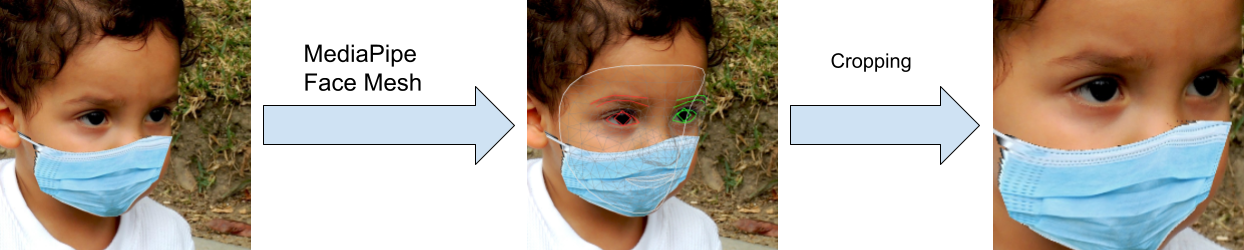

In [3]:
## instantation of the mediapipe solution and drawing tool
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

face=face_analysis()        #  Auto Download a large weight files from Google Drive.
face_mesh = mp_face_mesh.FaceMesh(
            max_num_faces=2,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5)

def files_in(path: str, valid_formats = "all"):
    '''
    A function that extract the name of the files inside a folder
    Args:
        Path: folder relative path
        valid_format: the formats that are acceptable
    '''
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and (splitext(f)[1] in valid_formats or valid_formats == "all")]
    return onlyfiles

def check_box(box):
    '''
    Check whether a box detected is meaningful or not
    Args:
        a box
    '''
    x, y, w, h = box
    if x<0 or y<0 or w<=3 or h<=3:
        return False
    return True

def cut_faces_by_yolo(original_image):
    '''
    Uses YOLOface to extract face boxes in an image
    Args:
        an image
    '''
    image = original_image.copy()
    _ , boxes, confs=face.face_detection(frame_arr=image, frame_status=True, model='full')
    faces = []
    #face.show_output(image,boxes)
    for box in boxes:
        if(not(check_box(box))):
            continue
        x, y, w, h = box
        print(box)
        cropped = original_image[y:y+w,x:x+h]
        faces.append(cropped)
    return faces

def extract_face_from_folder_yolo(in_path, out_path):
    '''
    feeds files in a folder to YOLOface
    '''
    files = files_in(in_path, valid_formats=['.png', '.jpg'])
    for file in files:
        filepath = join(in_path, file)
        image = cv2.imread(filepath)
        faces = cut_faces_by_yolo(image)
        print(len(faces))
        for i, a_face in enumerate(faces):
            filename = splitext(file)[0] + "-" + str(i) + ".png"
            output_file_path = join(out_path, filename)
            cv2.imwrite(output_file_path, a_face)
            #BGRimshow(a_face)

def extract_face_from_folder_mediapipe_face_mesh(in_path, out_path,expand=0.0):
    '''
    Uses MediaPipe face mesh to extract faces from files in a folder
    '''
    files = files_in(in_path, valid_formats=['.png', '.jpg'])
    for file in files:
        filepath = join(in_path, file)
        image = cv2.imread(filepath)
        if type(image).__name__=="NoneType":
            continue
        faces = cut_faces_by_mediapipe_face_mesh(image,expand=expand)
        #print(len(faces))
        if (faces == None):
            continue
        
        for i, a_face in enumerate(faces):
            filename = splitext(file)[0] + "-" + str(i) + ".png"
            output_file_path = join(out_path, filename)
            cv2.imwrite(output_file_path, a_face)
            #BGRimshow(a_face)

def BGRimshow(image):
    '''
    showing BGR image using MatplotLib
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other
    plt.imshow(image)
    plt.show()

def convert_landmarks_to_UV(landmarks, width, height):
    '''
    Convert MediaPipe Landmarks to UV coordinate
    '''
    accum = np.zeros((2,len(landmarks)), np.int)
    for i, landmark in enumerate(landmarks):
        accum[0,i] = int(landmark.x * width)
        accum[1,i] = int(landmark.y * height)
    return accum    

def cut_faces_by_mediapipe_face_mesh(original_image, expand=0.0):
    '''
    Uses YOLO face to extract face boxes in an image
    '''
    res = [original_image.shape[0],original_image.shape[1]]
    #print(res)
    image = original_image.copy()
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image)
    if results.multi_face_landmarks:
        c=convert_landmarks_to_UV(results.multi_face_landmarks[0].landmark, image.shape[1], image.shape[0])
        x_min, x_max, y_min, y_max = np.min(c[1,:]),np.max(c[1,:]),np.min(c[0,:]),np.max(c[0,:])
        w = x_max-x_min
        h = y_max-y_min
        x_min -= int(w*expand)
        x_max += int(w*expand)
        y_min -= int(h*expand)
        y_max += int(h*expand)
        if (x_min < 0) or (x_max > res[1]) or (y_min < 0) or (y_max > res[0]):
            return
        if (x_max-x_min<10) or (y_max-y_min<10):
            return
        fiximage=image[x_min:x_max, y_min:y_max, :]
        fiximage = cv2.resize(fiximage, (224, 224))
        fiximage = cv2.cvtColor(fiximage, cv2.COLOR_RGB2BGR)
        return [fiximage]




Downloading...
From: https://drive.google.com/uc?id=1JYrRT4Xe-NTrxYGhcj_hy7NtL4D2c77v
To: F:\deepl\.yoloface\yolov3-tiny_face.weights
100%|█████████████████████████████████████████████████████████████████████████████| 34.7M/34.7M [00:03<00:00, 11.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S4W6mpOQgVvjpPupbhW6rHFjl-OaUR-g
To: F:\deepl\.yoloface\yolov3_tiny_face.cfg
100%|█████████████████████████████████████████████████████████████████████████████| 2.09k/2.09k [00:00<00:00, 2.09MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EFlRsOA6oGLLBH2VMDOqHSfDI70CDXeW
To: F:\deepl\.yoloface\face_detection.weights
100%|███████████████████████████████████████████████████████████████████████████████| 246M/246M [00:21<00:00, 11.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZxUmO0B1435taazz8P0Pqjq8r8Rypeip
To: F:\deepl\.yoloface\face_detection.cfg
100%|█████████████████████████████████████████████████████████████████████████████| 8.34k/8.34k [00:00<00:00, 8.48MB

In [7]:
extract_face_from_folder_mediapipe_face_mesh(in_path='./Data-original/Masked', out_path='./Data/Masked',expand=0.1)

C:\Users\samir\AppData\Local\Temp\ipykernel_15984\4101752920.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accum = np.zeros((2,len(landmarks)), np.int)


In [8]:
extract_face_from_folder_mediapipe_face_mesh(in_path='./Data-original/Masked_Chin', out_path='./Data/Masked_Chin',expand=0.1)

C:\Users\samir\AppData\Local\Temp\ipykernel_15984\4101752920.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accum = np.zeros((2,len(landmarks)), np.int)


In [9]:
extract_face_from_folder_mediapipe_face_mesh(in_path='./Data-original/Masked_Mouth_Chin', out_path='./Data/Masked_Mouth_Chin',expand=0.1)

C:\Users\samir\AppData\Local\Temp\ipykernel_15984\4101752920.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accum = np.zeros((2,len(landmarks)), np.int)


In [10]:
extract_face_from_folder_mediapipe_face_mesh(in_path='./Data-original/UnMasked', out_path='./Data/UnMasked',expand=0.1)

C:\Users\samir\AppData\Local\Temp\ipykernel_15984\4101752920.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accum = np.zeros((2,len(landmarks)), np.int)


In [4]:
extract_face_from_folder_mediapipe_face_mesh(in_path='./Test-original/Masked', out_path='./Test/Masked',expand=0.1)


C:\Users\samir\AppData\Local\Temp\ipykernel_22984\4101752920.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accum = np.zeros((2,len(landmarks)), np.int)


FileNotFoundError: [WinError 3] The system cannot find the path specified: './Test-original/Masked_Chin'

In [5]:
extract_face_from_folder_mediapipe_face_mesh(in_path='./Test-original/Masked_Chin', out_path='./Test/Masked_Chin',expand=0.1)
extract_face_from_folder_mediapipe_face_mesh(in_path='./Test-original/Masked_Mouth_Chin', out_path='./Test/Masked_Mouth_Chin',expand=0.1)
extract_face_from_folder_mediapipe_face_mesh(in_path='./Test-original/UnMasked', out_path='./Test/UnMasked',expand=0.1)

C:\Users\samir\AppData\Local\Temp\ipykernel_22984\4101752920.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accum = np.zeros((2,len(landmarks)), np.int)


### 1-2- Dataset Prepared and Preprocessed

Below, are presented the 3 classes considered in the project.  

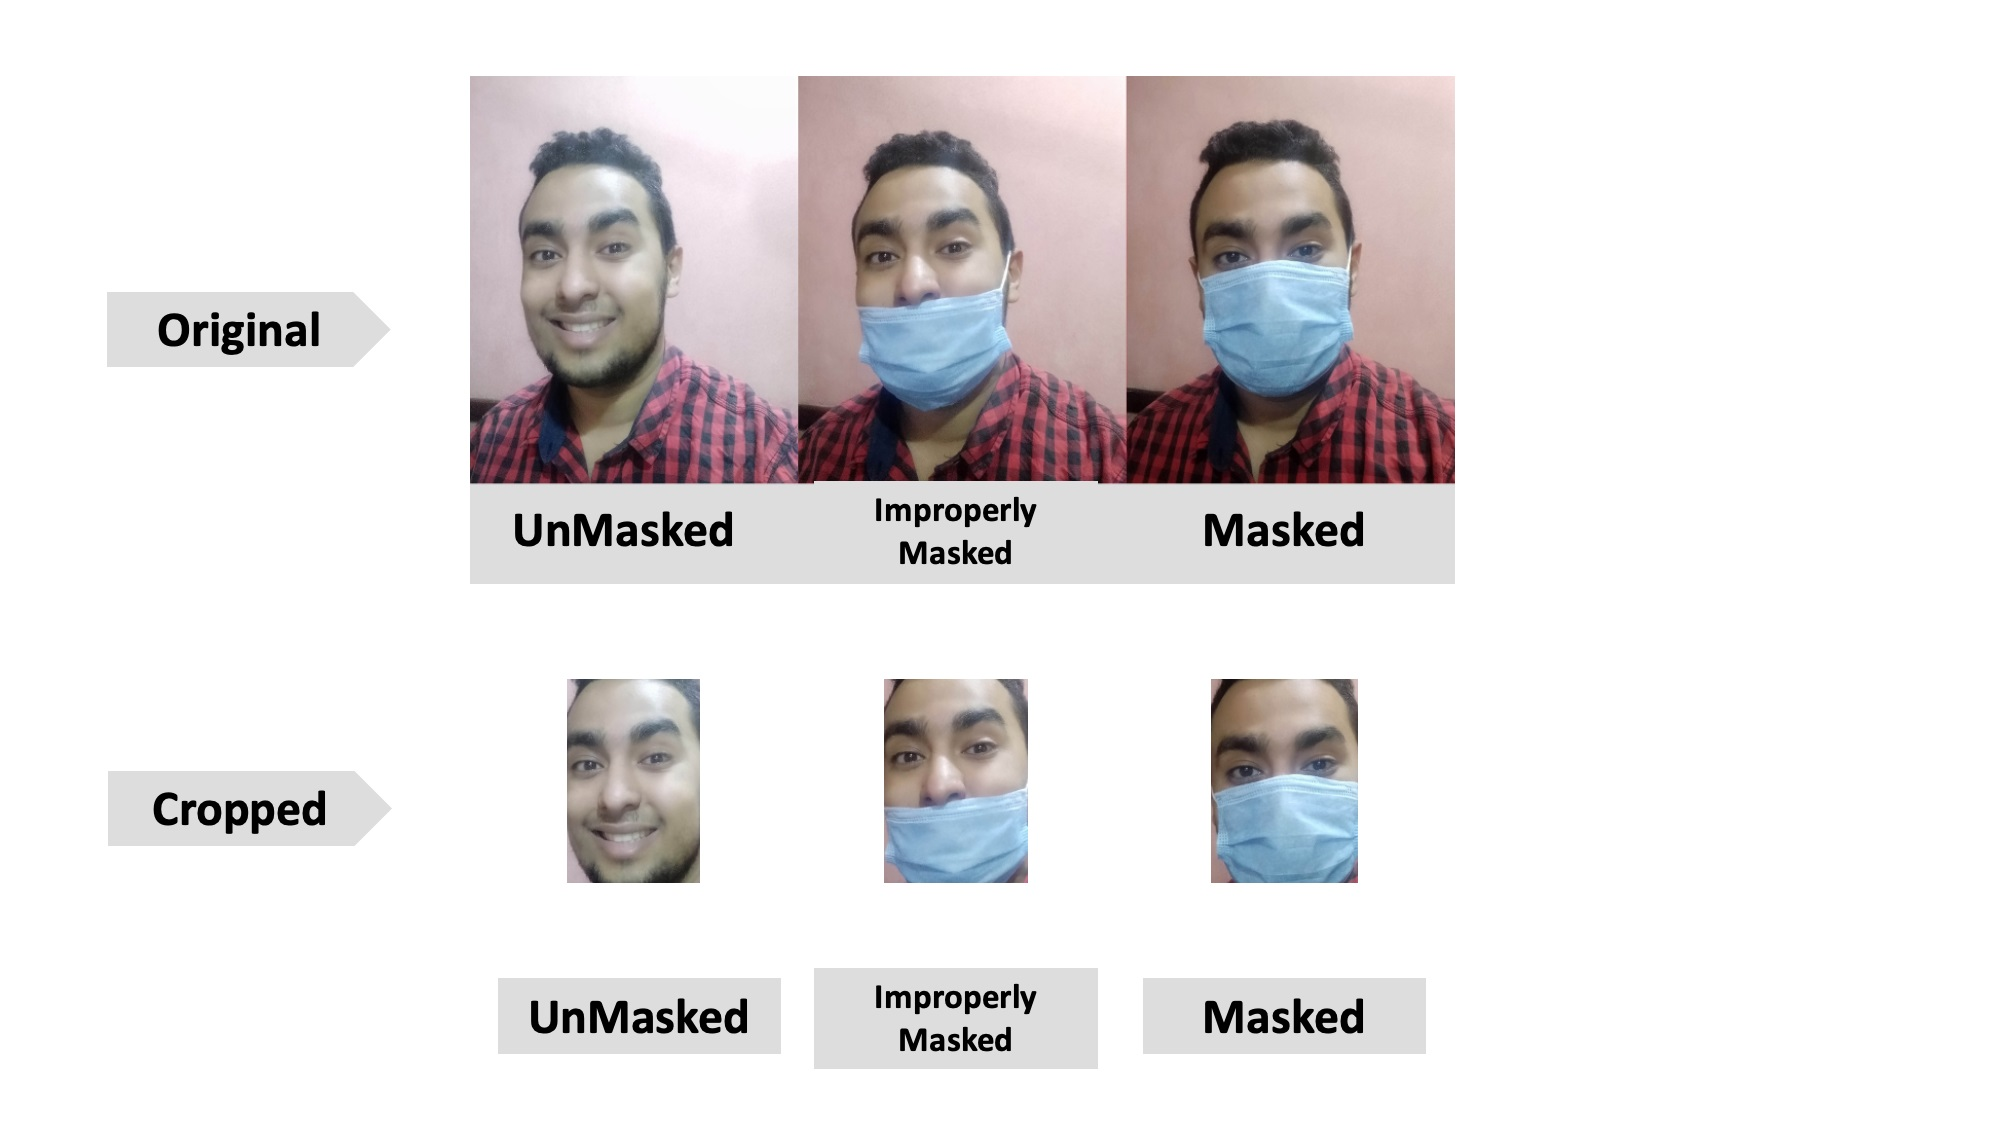

### 1-3- Dataset Verification

Below, we are verifying whether images are distributed correctly in the correspondig folders.

In [12]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["UnMasked", "Masked_Mouth_Chin", "Masked"],
    batch_size=128) 

Number of training examples =  1721
Number of validation examples =  431
Number of test examples =  311


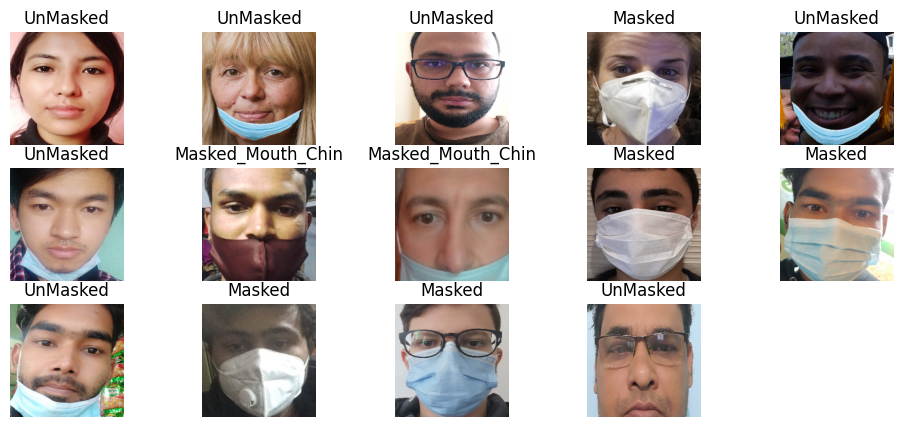

In [8]:
figure = plt.figure(figsize=(12,5))
k = 0
for images, labels in  train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classes[2-labels[0]])

    k += 1
    if k > 14:
        break

# 2. Train and Validation section
In what follows, we have defined all the functions utilized in the training and validation steps. 

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] 
        label_class = classes[label_index] 
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads dataset images, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ["UnMasked", "Masked_Mouth_Chin", "Masked"]
    #############################################################################################
    # Load data
    transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.ImageFolder(
        root='./Data', transform=transform)

    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]

    print("Number of training examples = ", len(relevant_indices[:split]))
    print("Number of validation examples = ", len(relevant_indices[split:])) 

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # 
    testset = torchvision.datasets.ImageFolder(
        root='./Test', transform=transform)
    
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)

    print("Number of test examples = ", len(relevant_test_indices))

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    
    return train_loader, val_loader, test_loader, classes, 

###############################################################################

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

# For evaluation
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [3]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data: #torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## 2-1. Dataloader

In the following subsection, we will load the data and split it into train, validation, and test datasets.

In [9]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["UnMasked", "Masked_Mouth_Chin", "Masked"],
    batch_size=128) 

Number of training examples =  1721
Number of validation examples =  431
Number of test examples =  311


## 2-2. Coming Up with a Reasonable Model

For the classifier part of the system, we have developed a model comprised of three convolutional layers followed by two fully-connected layers. To train our model, we first experimented with a few small datasets containing images in the order of 2000 images of masked and unmasked people. Although the results of our classifier were acceptable, we wanted to train our model with a much larger dataset to improve its accuracy. Below is a schematic of our classifier.
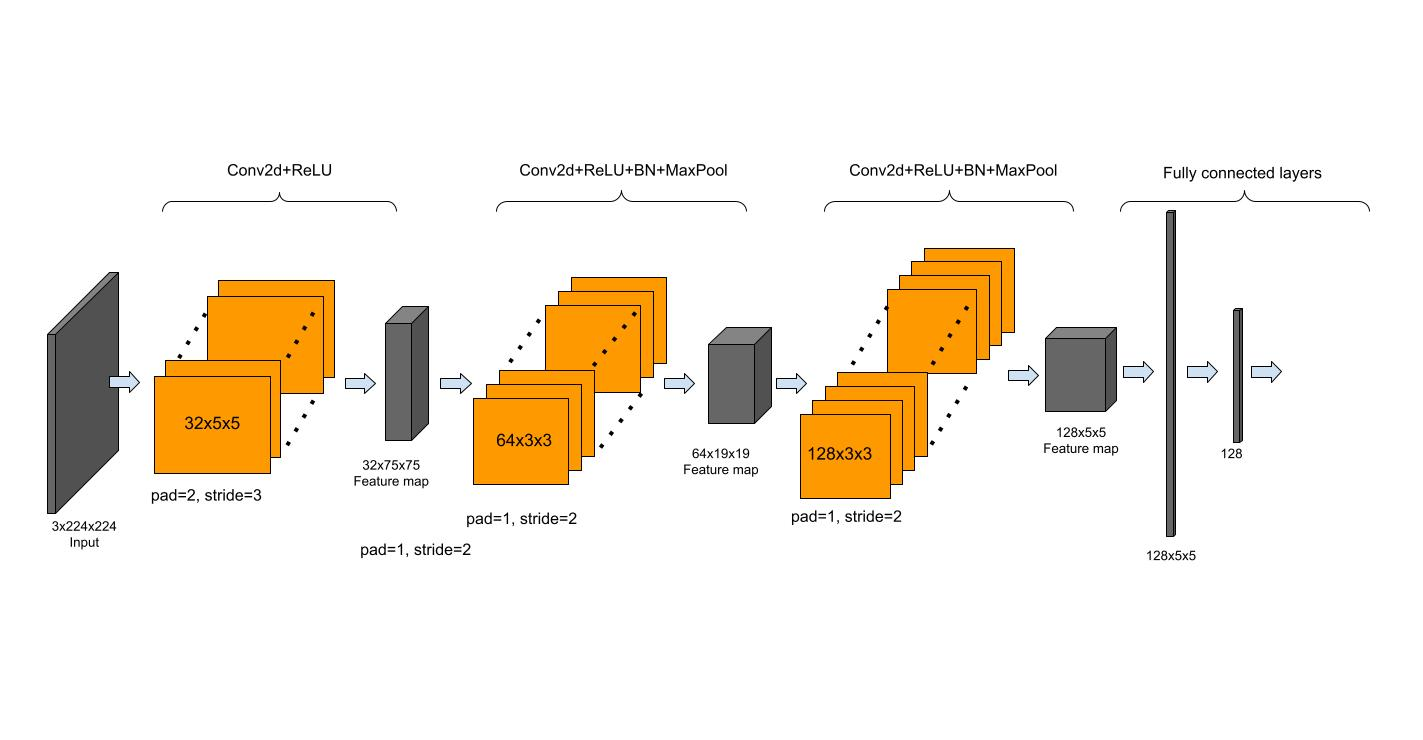

In [4]:
class CNN(nn.Module):

    def __init__(self, fully_connected_neurons, batch_norm, drop_outs, drop_outs_p):
        super(CNN, self).__init__()
        
        self.batch_norm = batch_norm
        self.drop_outs = drop_outs
        
        # CNN Layers
        ####################################################################
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=3, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        ####################################################################

        # Max Pool Layer
        ##################################
        self.maxpool = nn.MaxPool2d(2, 2)
        ##################################

        # batch normalization layer and dropout layers
        ##############################################################
        if batch_norm:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(128)
            self.bn3 = nn.BatchNorm2d(256)
        if drop_outs:
            self.do = nn.Dropout(p=drop_outs_p)
        ##############################################################

        # Fully Connected Layers
        #######################################
        self.fc1 = nn.Linear(128 * 5 * 5, fully_connected_neurons)
        self.fc2 = nn.Linear(fully_connected_neurons, 3)
        #######################################


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        if self.batch_norm:
            x = self.bn1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        if self.batch_norm:
            x = self.bn2(x)
        x = self.maxpool(x)

        x = x.view(-1, 128 * 5 * 5)
        if self.drop_outs:
            x = self.do(x)
        x = self.fc1(x)
        if self.drop_outs:
            x = self.do(x)
        x = self.fc2(x)        
        return x


## 2-3. Defining the training section

We used Adam as our optimizer and cross entropy as the loss function.

In [9]:
# Training
def train(model, train_loader, val_loader, batch_size=64, num_epochs=1,learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print("epoch = ", epoch)
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    

CUDA is available!  Training on GPU ...
epoch =  0
epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6


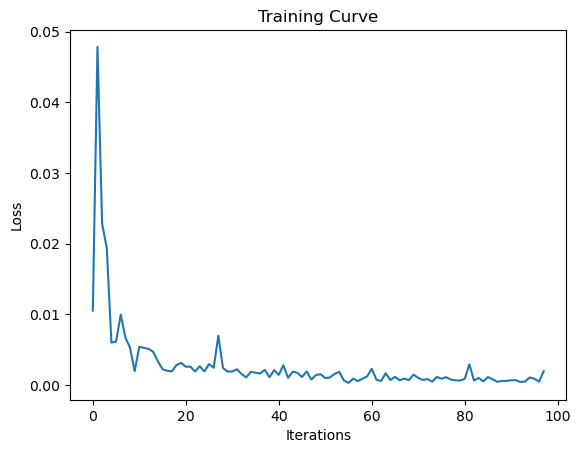

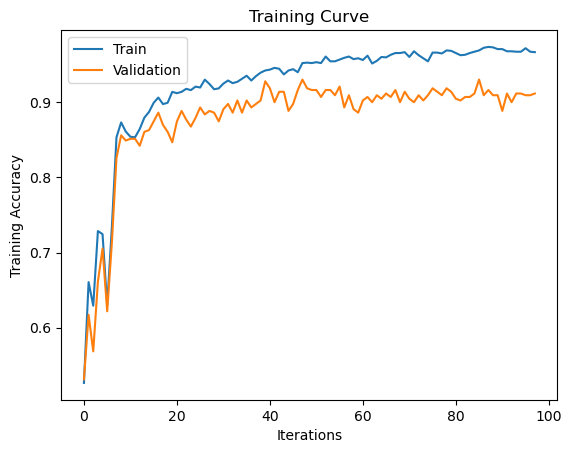

Final Training Accuracy: 0.9668797210923882
Final Validation Accuracy: 0.9118329466357309


In [11]:
use_cuda = True

model = CNN(fully_connected_neurons=128, batch_norm = True, drop_outs= True, drop_outs_p = 0.4)

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model, train_loader, val_loader, batch_size=128, num_epochs=7,learning_rate=0.001)

In [12]:
print("Total number of parameters = ", sum(p.numel() for p in model.parameters()))

Total number of parameters =  505795


In [13]:
torch.save(model.state_dict(), '.\epoch.pt')

### 2-4. Demonstrating performance on example test dataset

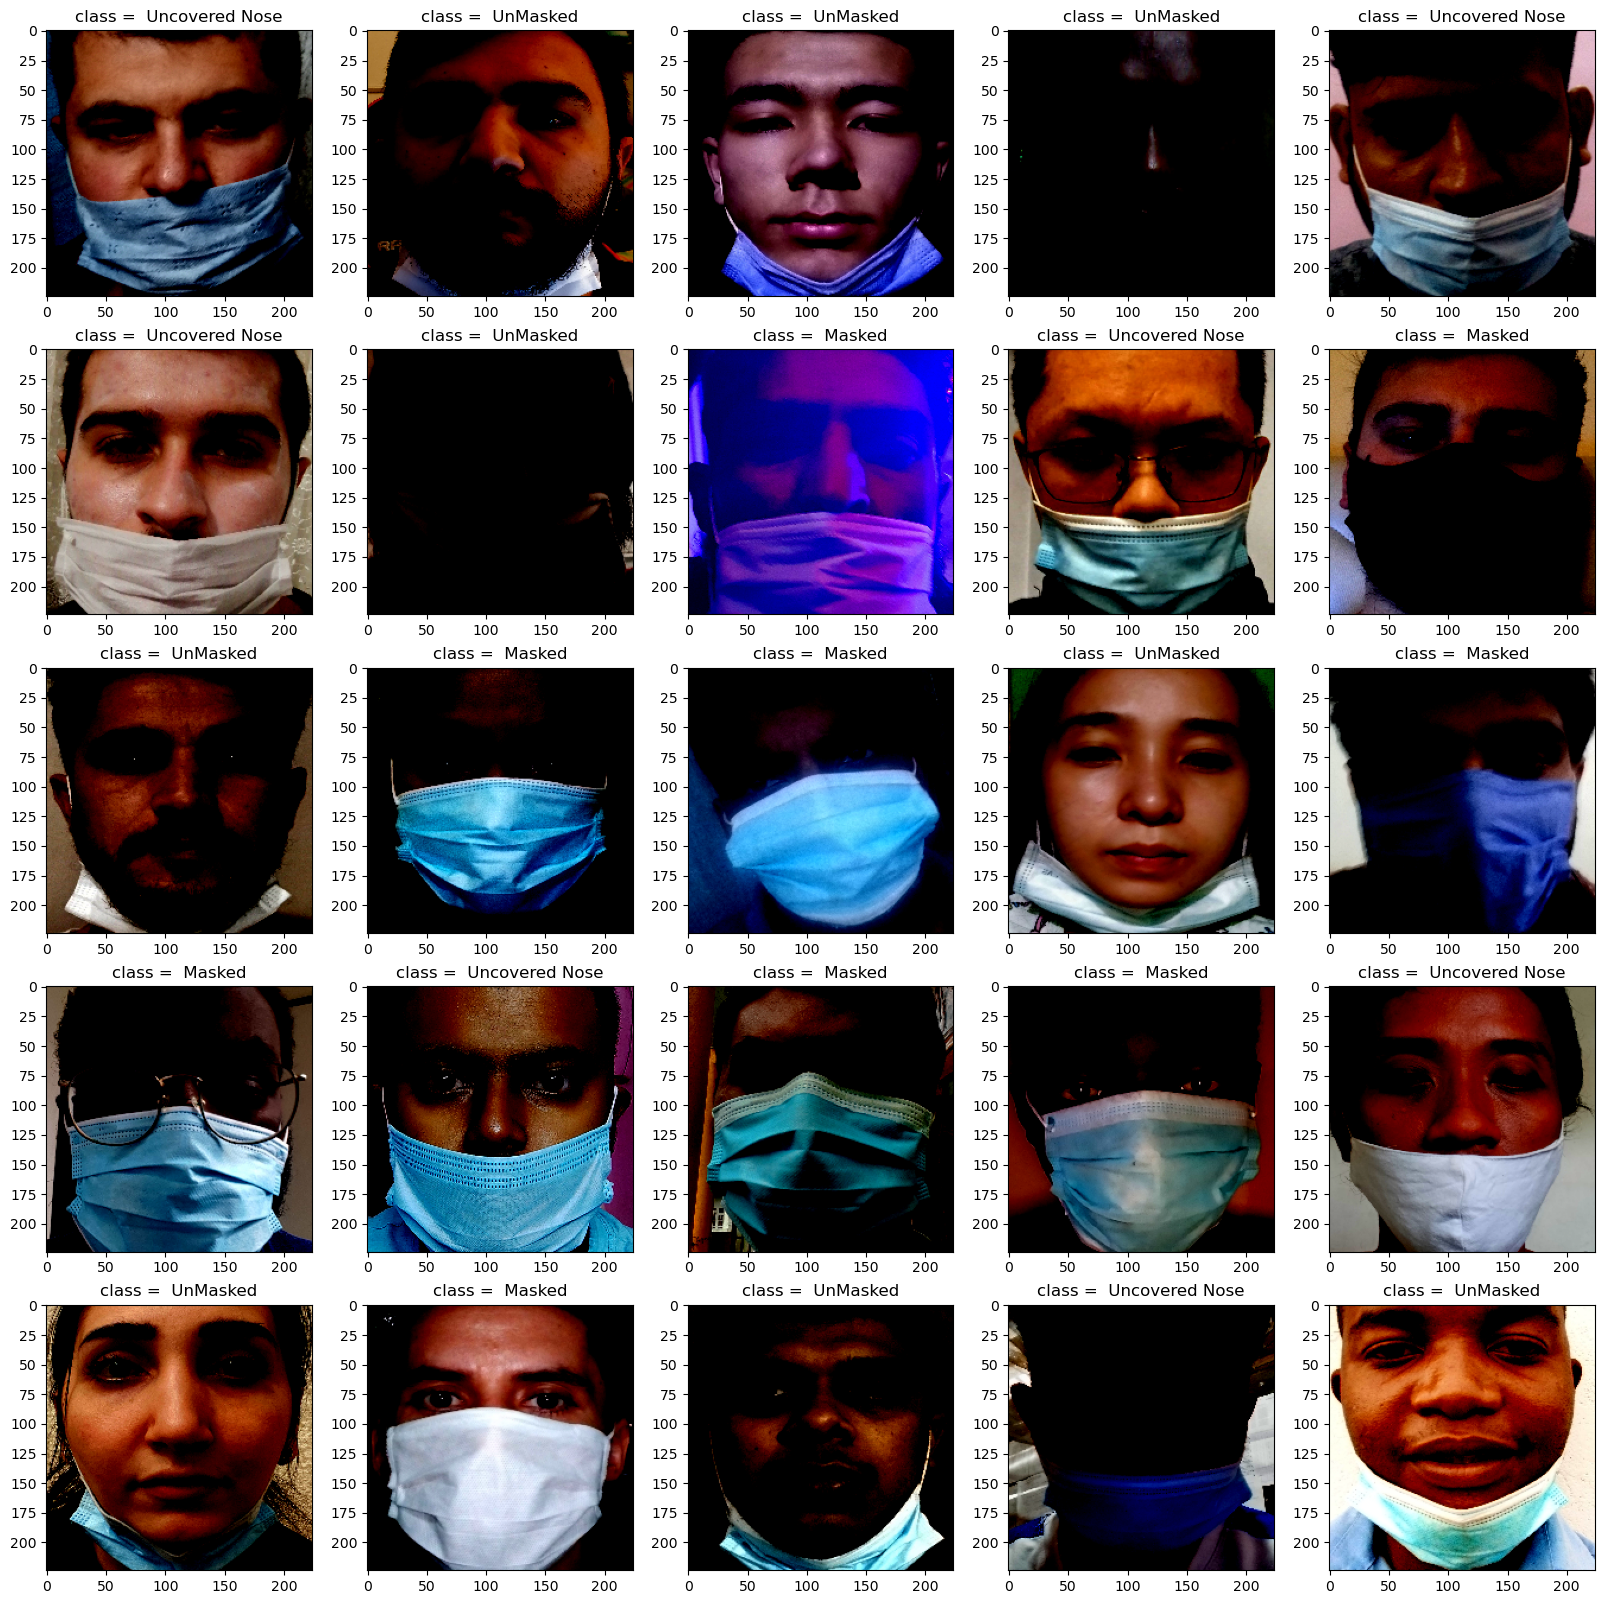

In [14]:
figure = plt.figure(figsize=(20,20))
SHOW_LABELS=["UnMasked", "Uncovered Nose", "Masked"]
for images, labels in test_loader:
    cudaimages = images.cuda()
    preds = model(cudaimages)
    m = nn.Softmax(dim=1)
    preds = m(preds)
    _, preds = torch.max(preds, dim=1)
    for i, image in enumerate(images):
        

        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)

        if i>24:
            break
        plt.subplot(5,5,i+1)
        plt.imshow(np.transpose(image,[1,2,0]))
        #plt.title('class = '+" "+str(classes[2-preds[i]]))
        plt.title('class = '+" "+str(SHOW_LABELS[2-preds[i]]))
        
        logger.setLevel(old_level)
plt.show()

## 3- Overall model performance

As you can see in the following performance analyses, our dataset preprocessing and model training are working very well. Particularly, the test accuracy of the model is 92.2% and the confusion matrix shows a well distributed error.


An example of a real-time analysis is as follows:

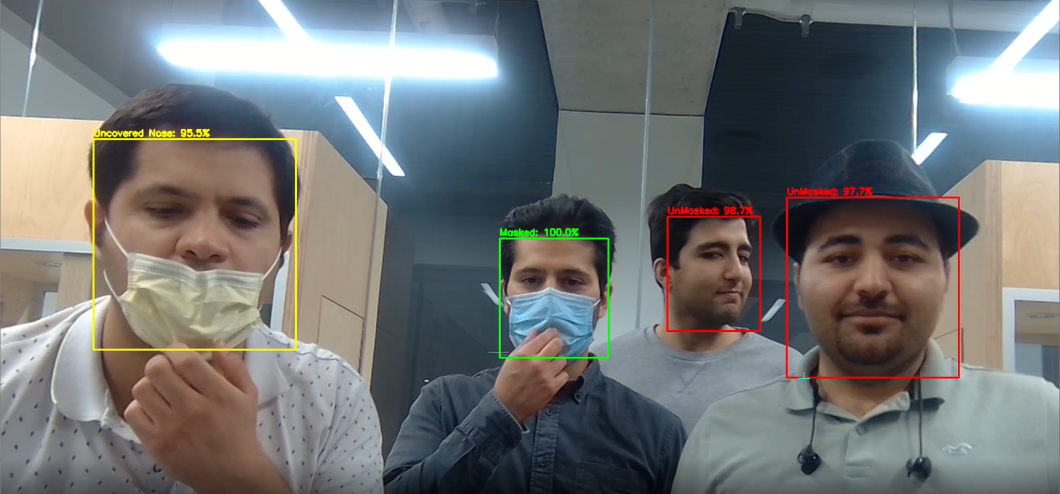

In [5]:
model = CNN(fully_connected_neurons=128, batch_norm = True, drop_outs= False, drop_outs_p = 0.4)
model.load_state_dict(torch.load('.\epoch.pt'))
model.eval()
model.cuda()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

<Figure size 2000x2000 with 0 Axes>

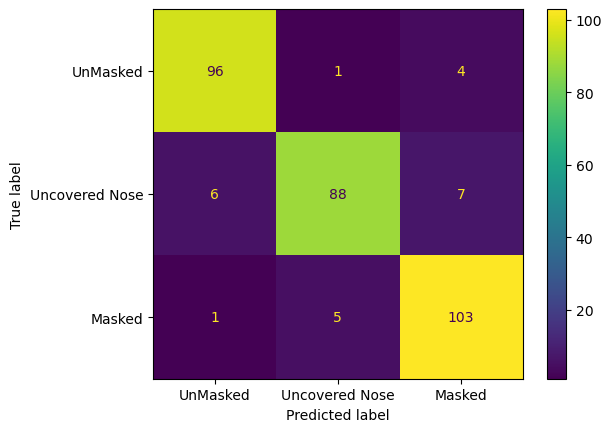

                precision    recall  f1-score   support

      UnMasked       0.93      0.95      0.94       101
Uncovered Nose       0.94      0.87      0.90       101
        Masked       0.90      0.94      0.92       109

      accuracy                           0.92       311
     macro avg       0.92      0.92      0.92       311
  weighted avg       0.92      0.92      0.92       311

Accuracy on the Test Dataset 92.2%


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

SHOW_LABELS=["UnMasked", "Uncovered Nose", "Masked"]
accum_preds = []
accum_labels = []
figure = plt.figure(figsize=(20,20))
for images, labels in test_loader:
    
    cudaimages = images.cuda()
    preds = model(cudaimages)
    m = nn.Softmax(dim=1)
    preds = m(preds)
    _, preds = torch.max(preds, dim=1)
    accum_preds += preds.cpu()
    accum_labels += labels



cm = confusion_matrix(accum_labels, accum_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=SHOW_LABELS)

disp.plot()
plt.show()

from sklearn.metrics import precision_recall_fscore_support, classification_report
precision_recall_fscore_support(accum_labels, accum_preds, average='macro')
print(classification_report(accum_labels, accum_preds, target_names=SHOW_LABELS))
#print("Accuracy on the Test Dataset", 100*balanced_accuracy_score(accum_labels, accum_preds), "%")
pqp=100*balanced_accuracy_score(accum_labels, accum_preds)
print("Accuracy on the Test Dataset {num:.1f}%".format(num=pqp))

# 4- Implementation of real-time test on webcam feed

Execution instruction:

1- Install all dependencies 

2- Load network

3- Load model weights

4- Run the following cell

In [ ]:
## executing the online implementation of the model

import cv2
import mediapipe as mp
import numpy as np

## Instantiation of the MediaPipe solutions and drawing tool
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

from IPython.display import clear_output


## webcam resolution 
webcam_res = [1920, 1080]


## colors that will be used for overlaying the results
COLORS=[(0,255,0),
        (0,255,255),
        (0,0,255)]


## labels that will be shown above the overlaid bonding boxes
SHOW_LABELS=['UnMasked', 'Uncovered Nose', 'Masked']

## mediapipe returns the coordination of the face as a value between 0 and 1
def convert_landmarks_to_UV(landmarks, width, height):
    '''
    converting mediapipe landmarks normalized coordination to pixel's coordinations
    args:
        landmarks: from mediapipe
        width: image width
        height: image height
    '''
    accum = np.zeros((2,len(landmarks)), np.int)
    for i, landmark in enumerate(landmarks):
        accum[0,i] = int(landmark.x * width)
        accum[1,i] = int(landmark.y * height)
    return accum

# opening a stream to the webcam
## changing the code in the pranthesis you can switch between your cameras
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
cap = cv2.VideoCapture(0)


## setting camera resolution and frame per second
cap.set(cv2.CAP_PROP_FRAME_WIDTH, webcam_res[0])
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, webcam_res[1])
cap.set(cv2.CAP_PROP_FPS, 30)


## creating a transformation to convert an image with [0,1] range to [-1, 1] range
transform = transforms.Normalize((
    0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

## expand: this value will show the percentage of the width and height of the bonding box
## with a expand value equal to 0.1 the cropped image will be 10 perccent larger that the 
expand=0.1
with mp_face_mesh.FaceMesh(max_num_faces=5,
                           refine_landmarks=True,
                           min_detection_confidence=0.3,
                           min_tracking_confidence=0.5) as face_mesh:
    ## continue live analysis while webcam is in servicee    
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print('Ignoring empty camera frame.')
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # To improve performance, optionally mark the image as not writeable to
        # for opencv it is like pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ## feeding the frame into mediapipe
        results = face_mesh.process(image)
    
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        #doing the classification if any face is/are detected
        if results.multi_face_landmarks:
            accum_image = []
            accum_bbox = []
            for face_landmarks in results.multi_face_landmarks:

                c=convert_landmarks_to_UV(face_landmarks.landmark, image.shape[1], image.shape[0])
                
                # selecting a bigger bonding box based on "expand"
                x_min, x_max, y_min, y_max = np.min(c[1,]),np.max(c[1,]),np.min(c[0,]),np.max(c[0,])
                w = x_max-x_min
                h = y_max-y_min
                x_min -= int(w*expand)
                x_max += int(w*expand)
                y_min -= int(h*expand)
                y_max += int(h*expand)

                # rejecting faces that fall outside the image
                if (x_min < 0) or (x_max >= webcam_res[1]) or (y_min < 0) or (y_max >= webcam_res[0]):
                    continue
                clear_output(wait=True)
                print(x_min, x_max, y_min, y_max)
                # rejecting small images
                if (x_max-x_min<10) or (y_max-y_min<10):
                    continue

                ## cropping and preparing each face to be feed into model
                cropped_image = image[x_min:x_max, y_min:y_max, :]
                cropped_image = cv2.resize(cropped_image, (224, 224))
                cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
                cropped_image = transform(torch.from_numpy(np.transpose(cropped_image,(2,0,1))).float()*255)
                cropped_image = torch.unsqueeze(cropped_image, 0)
                # creating a batch of faces present in the image
                accum_image.append(cropped_image)
                accum_bbox.append([x_min, x_max, y_min, y_max])

            # converting the batch into tensor
            batch=torch.Tensor([])

            # if the batch is not empty
            if len(accum_image)>0:
                torch.cat(accum_image, out=batch)
                cudaimages = batch.cuda()
                #print(cudaimages.shape)
                #print(cudaimages)
                preds = model(cudaimages)

                ## applying softmax
                m = nn.Softmax(dim=1)
                probablity = m(preds)
                _, preds = torch.max(probablity, dim=1)

                # drawing the bonding box around 
                for i, pred in enumerate(preds):
                    cv2.rectangle(image,(accum_bbox[i][2],accum_bbox[i][0]), (accum_bbox[i][3],accum_bbox[i][1]), COLORS[pred], 2)
                    text = "{} {.1f}%".format(SHOW_LABELS[2-pred], probablity[i][pred]*100)
                    cv2.putText(image, text, (accum_bbox[i][2], accum_bbox[i][0]- 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[pred], 2)

        cv2.imshow('MediaPipe Face Mesh', image)

        ## exiting the online webcam processing by ESC
        if cv2.waitKey(5) & 0xFF == 27:
                break
                
# closing the webcam and windows
cap.release()
cv2.destroyAllWindows()

# 5- Discussion

As you can see in the previous performance analyses, our dataset preprocessing and model training are working very well. Particularly, the test accuracy of the model is 92.2% and the confusion matrix shows a well distributed error.

### 5-1. What we learned ...

As a result of this project, we have learned the following:

1. YOLO is not necessarily the best object detection framework for every application, and some specialized detectors may work better than Yolo in some cases

2. In order for a model to perform well, a well-prepared dataset is one of the most important factors

3. The computational cost of running ResNet and VGG is so great that real-time execution will not be feasible
 

### 5-2. Surprising result ...
 
 1- It seems that users may be able to deceive our model using mask-resembling objects. To solve this issue, the model should be trained with a comprehensive dataset which also contains possible mask-resembling objects labeled as fake.  
 
 2- Despite using a relatively small dataset, our model performed surprisingly well in detecting masked people on real-time tests.

### Thank You for Taking the Time